# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

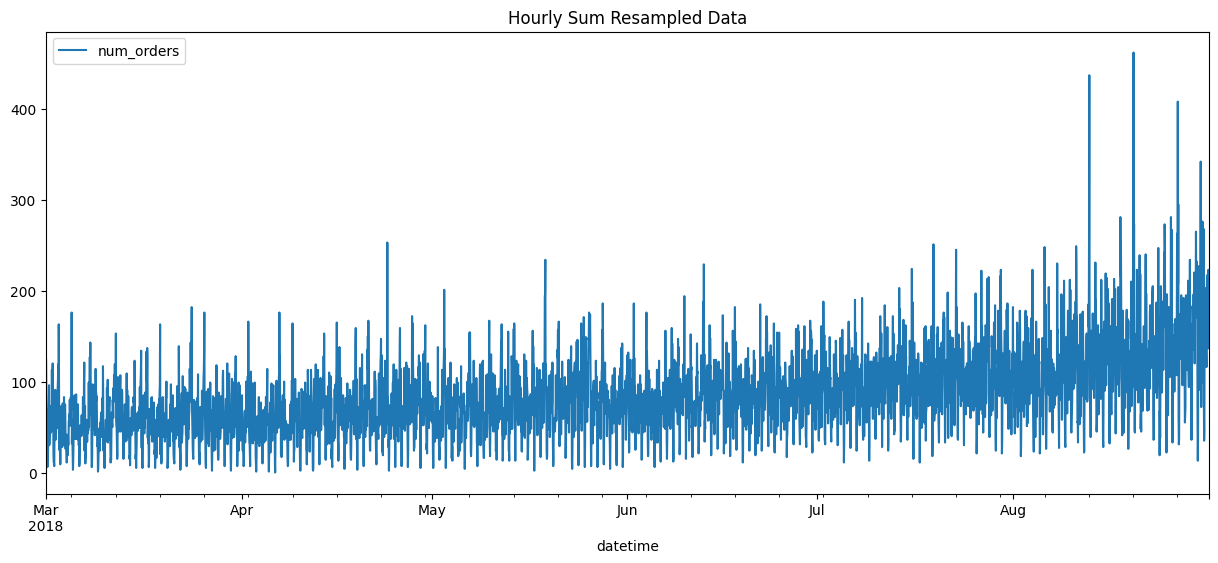

In [1]:
#Load Libraries Here
import time
import itertools
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics  import f1_score, mean_squared_error, r2_score
from pmdarima import auto_arima
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [2]:
#load Data Here
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

## Analysis

During the data pre-processing phase, the 'usual' was executed from getting a glimpse of what the data reveals (missing values, shape, dtypes, etc) to manipulating the data (dropping, renaming, and separting by numerical or categorical). I went ahead and explored whether or not the date & time is in chronological order and it is, actually!

In [3]:
df.shape

(26496, 1)

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)
print(df.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [6]:
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
df.duplicated().sum()

26415

In [8]:
df['num_orders'].unique()

array([  9,  14,  28,  20,  32,  21,   7,   5,  17,  12,  19,  25,  22,
         8,   6,   4,  10,  13,   2,   3,   0,   1,  11,  15,  16,  23,
        18,  33,  24,  26,  30,  38,  34,  42,  31,  27,  36,  29,  35,
        56,  37,  40,  39,  45,  49,  58,  68,  43,  53,  44,  41,  52,
        46,  57,  47,  64,  61,  50,  48,  55,  62,  54,  71,  78, 119,
        99,  51,  60,  87,  90,  94,  82,  80,  91,  76,  66,  65,  98,
        81,  95,  67])

Comparatively, the histplot and the series' value counts' results shows how the quantity predominately lies in range of 8 to 12 digit value - which would be my biggest guesstimate.

In [9]:
df['num_orders'].value_counts()

9     1373
11    1365
12    1317
10    1316
8     1253
      ... 
67       1
66       1
91       1
82       1
95       1
Name: num_orders, Length: 81, dtype: int64

Text(0.5, 0, 'Number of Orders In 10 Minute-Intervals')

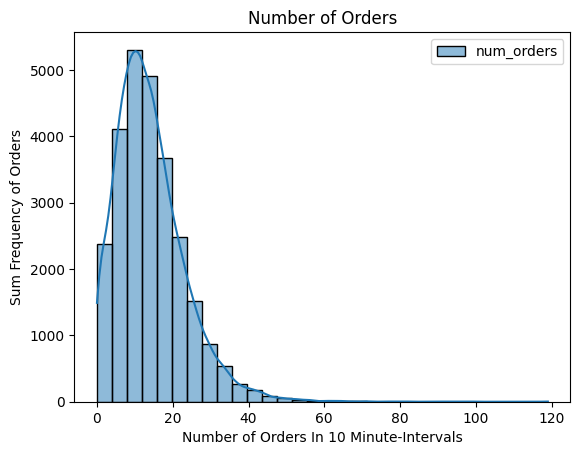

In [10]:
sns.histplot(df, kde=True, bins=30)
plt.title('Number of Orders')
plt.ylabel('Sum Frequency of Orders')
plt.xlabel('Number of Orders In 10 Minute-Intervals')

### Time Series & Resampling By Sum

I visually plotted the dataframe's data to get a glimpse of what its Time Series look like before resampling.

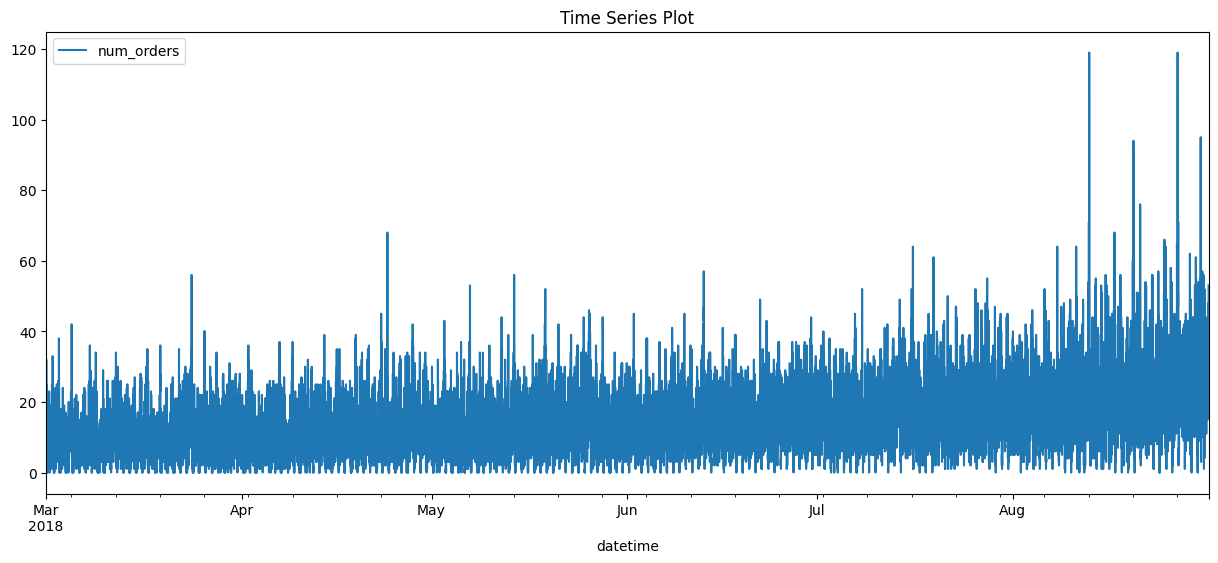

In [11]:
df.plot(figsize=(15, 6))
plt.title('Time Series Plot')
plt.show()

I resampled the data by an hour and aggregated by the sum; futhermore, I also looked at other time intervals as well.

#### Hourly Resampling

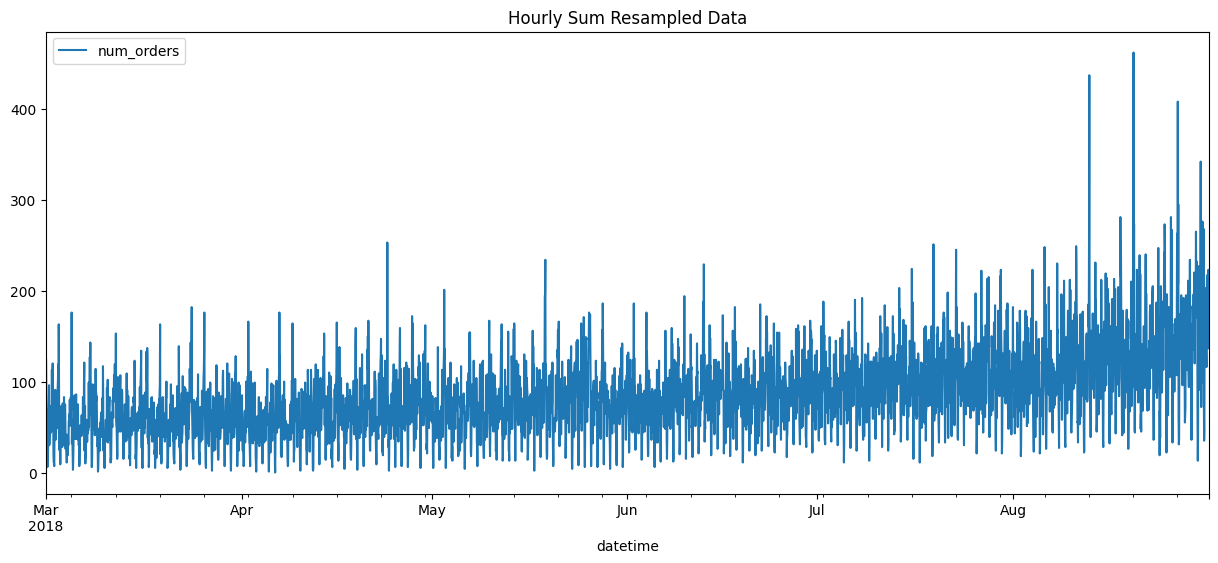

In [12]:
df_resampled = df.asfreq('H')
df_resampled = df.resample('H').sum()
df_resampled.plot(figsize=(15, 6))
plt.title('Hourly Sum Resampled Data')
plt.show()

#### Daily Resampling

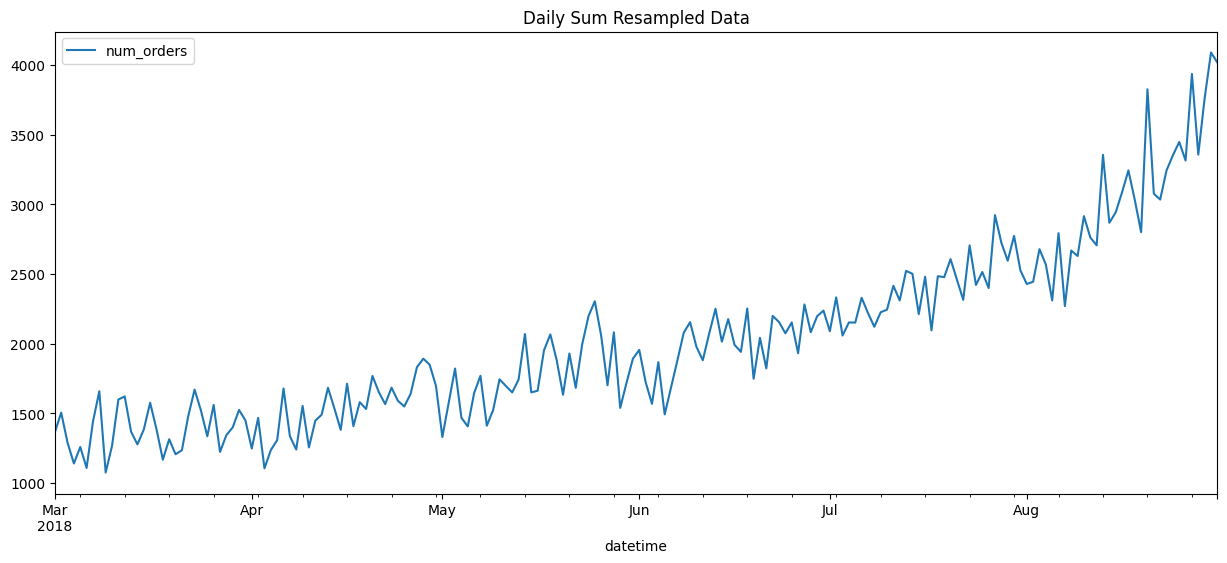

In [13]:
daily_data = df.resample('D').sum()
daily_data.plot(figsize=(15, 6))
plt.title('Daily Sum Resampled Data')
plt.show()

#### Bi-Weekly Resampling

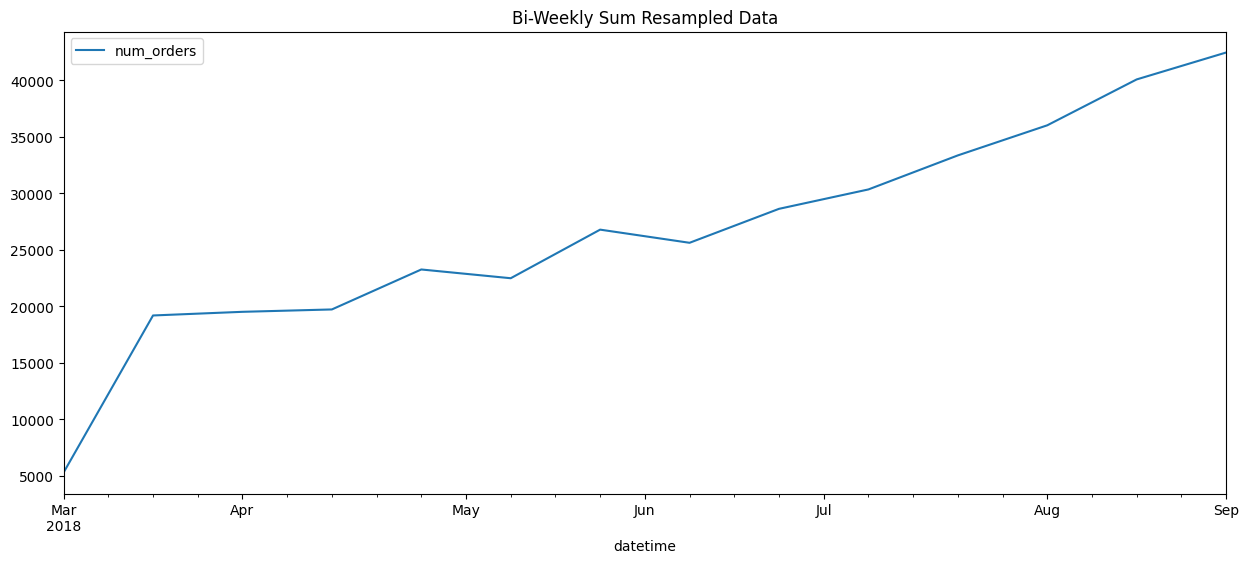

In [14]:
biweekly_data = df.resample('2W').sum()
biweekly_data.plot(figsize=(15, 6))
plt.title('Bi-Weekly Sum Resampled Data')
plt.show()

#### Bi-Monthly Resampling

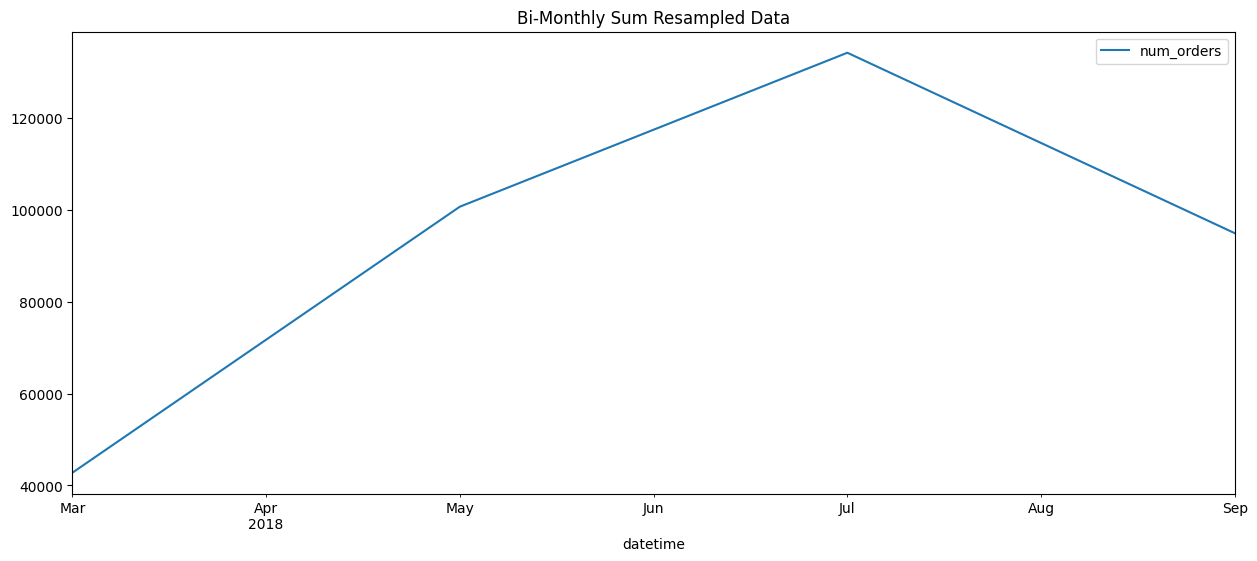

In [15]:
bimonthly_data = df.resample('2M').sum()
bimonthly_data.plot(figsize=(15, 6))
plt.title('Bi-Monthly Sum Resampled Data')
plt.show()

The initial TS plot, along side the resampled data, is showcasing an increasing, upward trend (and thus a demand) in the number of orders (for taxis) as the months go by from March - August/September 2018. I think seasonality wise, there are some cyclical patterns that are present and depicted in both plots - but maybe more so, explicitly, a pattern seen on a daily or weekly basis with the resampling. For example, for the daily resample, maybe the spikes imply that there are promotional events being pushed to riders due to the month or possibly incentives for drivers to choose a certain route or area based on the distance. Although this trend or cyclical pattern is shown more on a daily basis, it is smoothen out further in the bi-weekly to bi-monthly resampling. There's signs of peak orders between the June-July period and peak drops between the Aug-Sept period in the bi-monthly resampling. Thus showing resampling at different intervals can show us a different perspective on the data. 

I also went head and explored the Time Series' decomposition elements and as well as the shifted differences, to see if there was anything notable.

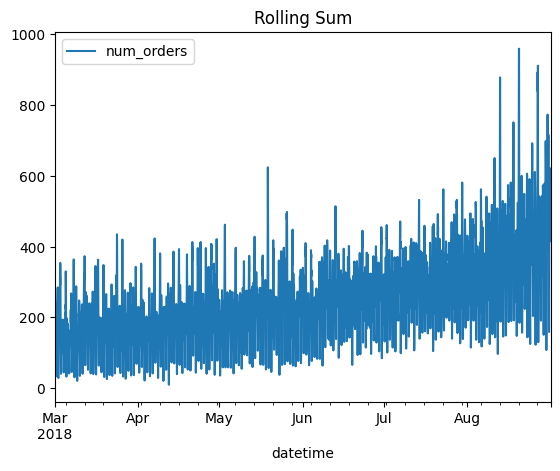

In [16]:
df_resampled.rolling(3).sum().plot(title='Rolling Sum')
plt.show()

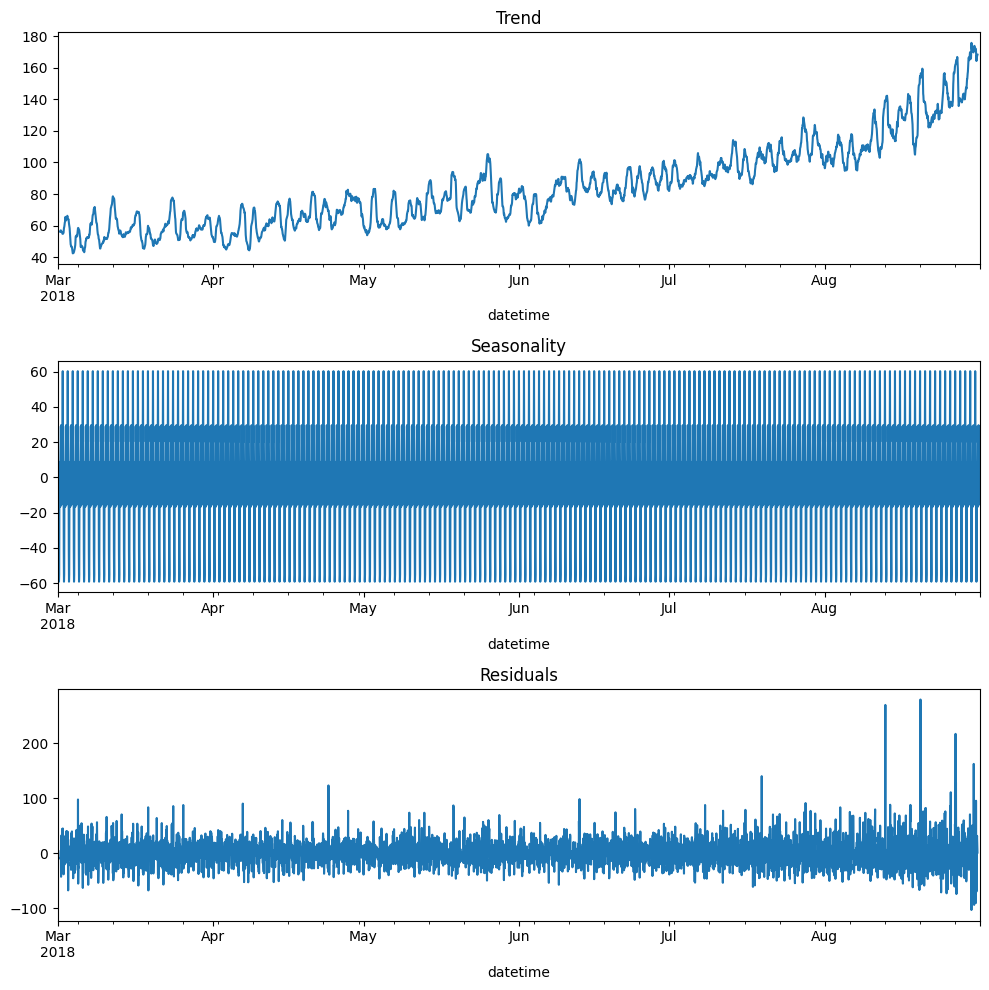

In [17]:
decomposed = seasonal_decompose(df_resampled)
plt.figure(figsize=(10,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:title={'center':'TS Differences'}, xlabel='datetime'>

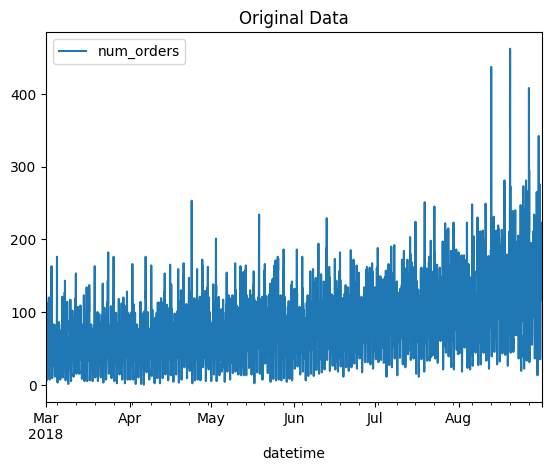

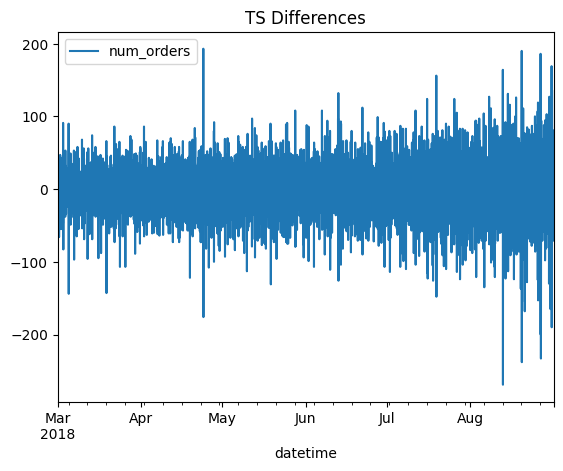

In [18]:
shift_df = df_resampled.shift().dropna()
diff_df = df_resampled-shift_df

df_resampled.plot(title='Original Data')
diff_df.plot(title='TS Differences')

With the dataframe resampled, I extracted the time elements of each row of data and plotted the sum results by hour of the day and day of the week to see if there's any significance. 

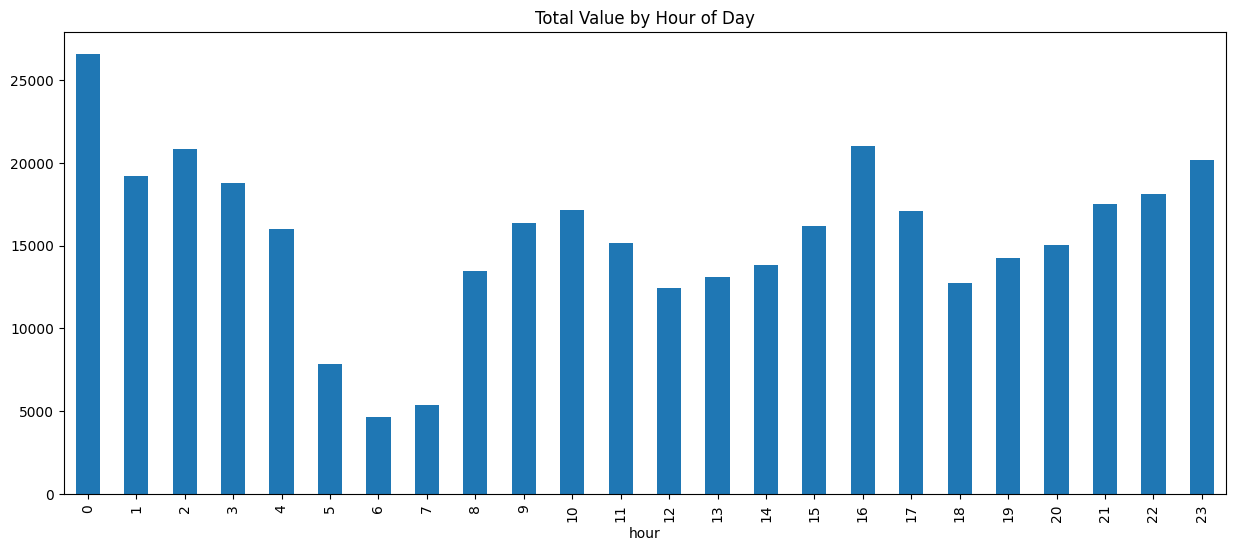

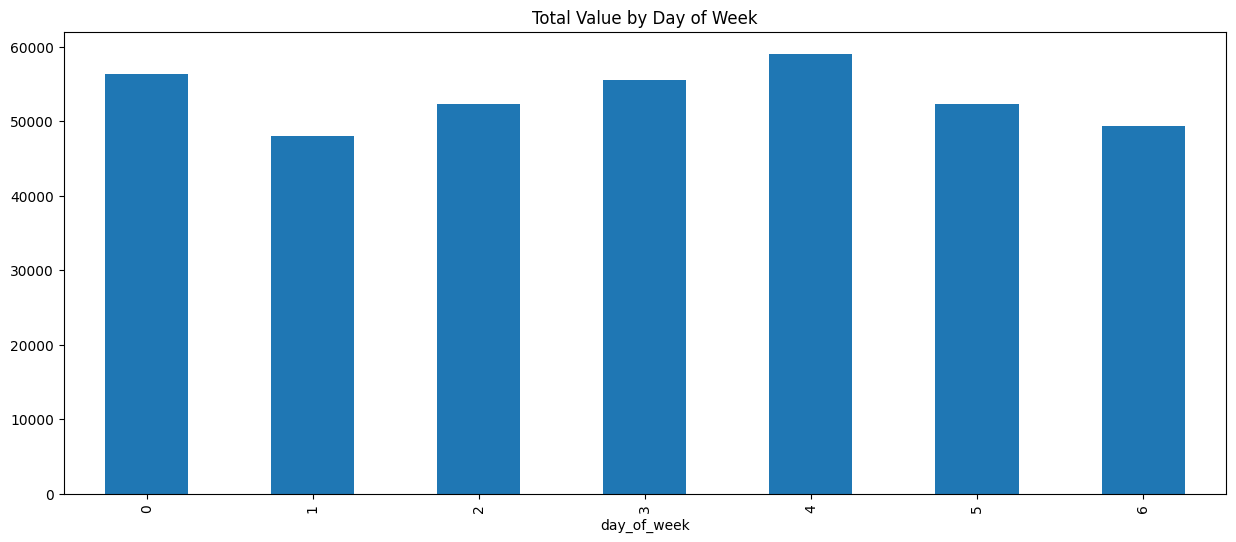

In [19]:
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
df_resampled['month'] = df_resampled.index.month

# Plotting mean values by time features
hour_sum = df_resampled.groupby('hour')['num_orders'].sum()
hour_sum.plot(kind='bar', figsize=(15, 6))
plt.title('Total Value by Hour of Day')
plt.show()

day_sum = df_resampled.groupby('day_of_week')['num_orders'].sum()
day_sum.plot(kind='bar', figsize=(15, 6))
plt.title('Total Value by Day of Week')
plt.show()

As mentioned before, there's a clear upward trend in the taxi demand within our 7-month historical data. Given that on a daily level the seasonality pattern suggests there's a consistent pattern and further proven with the rolling sum and seasonality plot. As for the patterns found in the Hourly & Daily timeframes, I believe the peak hours hit "evenly" around the early morning and evening around 4-5 am & pm respectfully, although around 12 - 1 am and 6 - 7 am, respectfully, you see the highest and lowest peaks of rides within that 1-hour timeframe. Furthermore in terms of day of the week (and if I'm assuming 0 is Sunday & 6 Saturday), Thursday and following Sunday have the highest amount of orders (i.e. the most busiest); meanwhile Saturday has the lowest amount of orders being produced in the week (i.e. not the most busiest). As for the September month, I can only assume maybe, given we're working to forecast future data, my biggest guest is the month will have a continious upward trend as more and more orders will increase.

## Training

In [20]:
train, test = train_test_split(df_resampled, shuffle=False, test_size=0.10)

In [21]:
adf_test = adfuller(train['num_orders'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] < 0.05:
    print("The series is steady (stationary).")
    train_diff = train['num_orders']
else:
    print("The series is not steady. Adjust it.")
    train_diff = train['num_orders'].diff().dropna()
    
train_diff_filled = train_diff.fillna(0)

ADF Statistic: -4.172825745847444
p-value: 0.0007322730527364293
The series is steady (stationary).


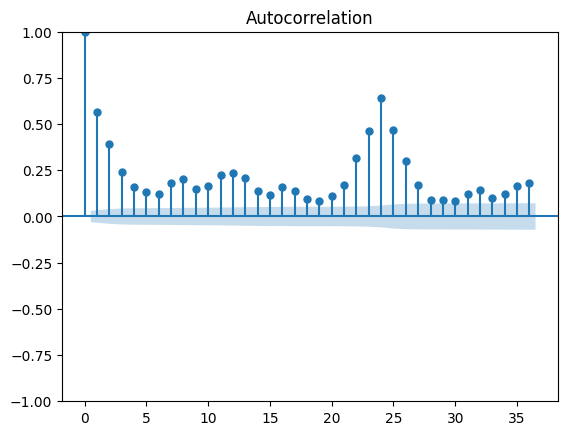

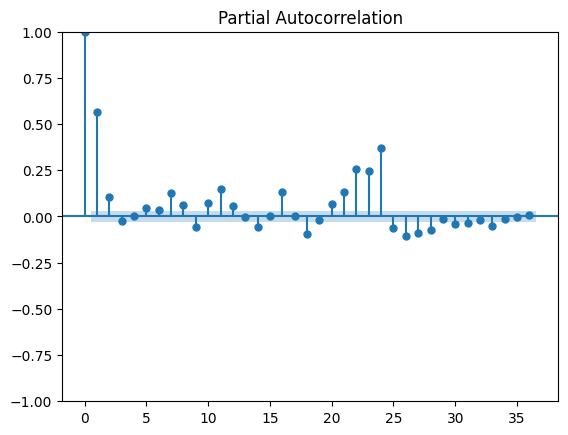

In [22]:
plot_acf(train_diff_filled)
plot_pacf(train_diff_filled)
plt.show()

If I'm not mistaken, I believe the orders of the models are 0? But I'm not sure if I'm overlooking anything when looking at the PACF & ACF but I decided to use hyperparamters for the models to see which order variables are found the most optimal through comparison.

## AR Model

In [23]:
lags = range(1, 31)

best_rmse = float('inf')
best_lag = None
best_ar_model = None

for lag in lags:
    try:
        ar_model = AutoReg(train['num_orders'], lags=lag).fit()
        start_index = len(ar_model.params) - 1
        ar_train_pred = ar_model.predict(start=start_index, end=len(train)-1, dynamic=False)
        
        ar_train_pred = pd.Series(ar_train_pred, index=train.index[start_index:])
        train_dropped = train['num_orders'].iloc[start_index:]
        ar_train_pred_dropped = ar_train_pred.iloc[:len(train_dropped)]
        
        ar_train_rmse = sqrt(mean_squared_error(train_dropped, ar_train_pred_dropped))
        if ar_train_rmse < best_rmse:
            best_rmse = ar_train_rmse
            best_lag = lag
            best_ar_model = ar_model

    except Exception as e:
        print(f'Error for lag={lag}: {e}')
        continue

print(f'Best AR lag: {best_lag} with RMSE: {best_rmse}')

Best AR lag: 30 with RMSE: 25.578740831881873


Best AR lag: 30 with RMSE: 25.578740831881873
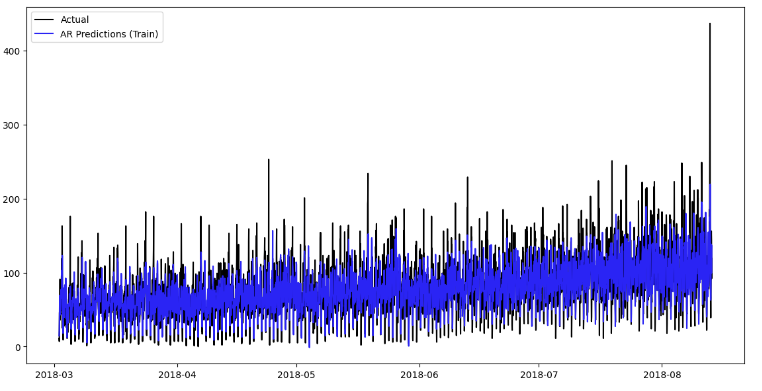

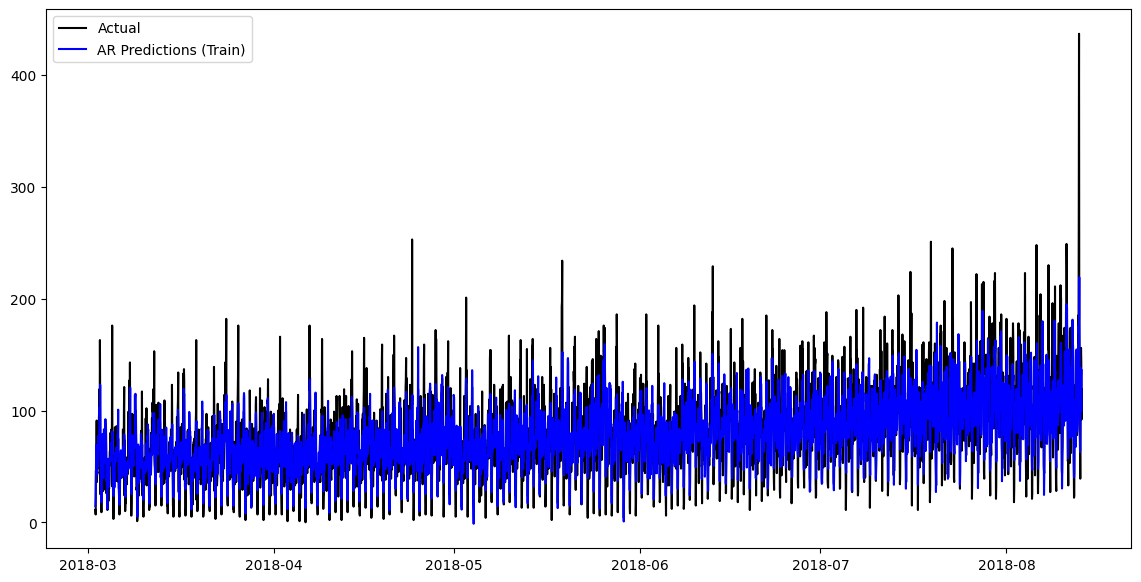

In [24]:
# refer to the image above
plt.figure(figsize=(14, 7))
plt.plot(train_dropped.index, train_dropped, label='Actual', color='black')
plt.plot(ar_train_pred_dropped.index, ar_train_pred_dropped, label='AR Predictions (Train)', color='blue')
plt.legend()
plt.show()

## ARMA Model

In [25]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

p_values = range(0, 6)  # AR values
q_values = range(0, 6)  # MA values

best_rmse = float('inf')
best_order = None
best_arma_model = None

for p in p_values:
    for q in q_values:
        try:
            arma_model = ARIMA(train['num_orders'], order=(p, 0, q)).fit()
            arma_train_pred = arma_model.fittedvalues
            arma_train_rmse = sqrt(mean_squared_error(train['num_orders'], arma_train_pred))

            if arma_train_rmse < best_rmse:
                best_rmse = arma_train_rmse
                best_order = (p, q)
                best_arma_model = arma_model

        except Exception as e:
            print(f'Error for order=({p}, {q}): {e}')
            continue

print(f'Best ARMA order: {best_order} with RMSE: {best_rmse}')

Best ARMA order: (5, 4) with RMSE: 30.138340903179895


Best ARMA order: (5, 4) with RMSE: 30.138340903179895
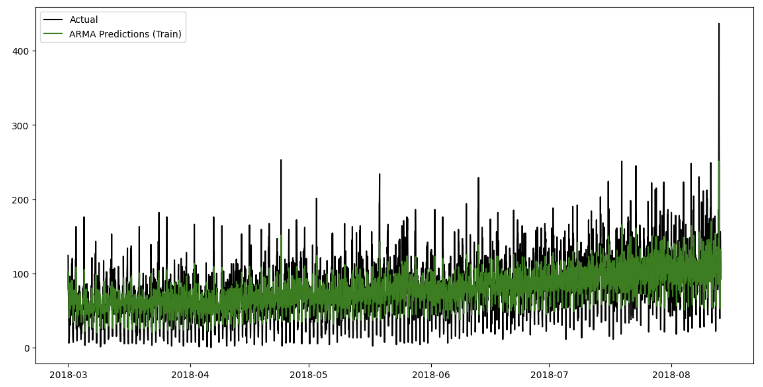

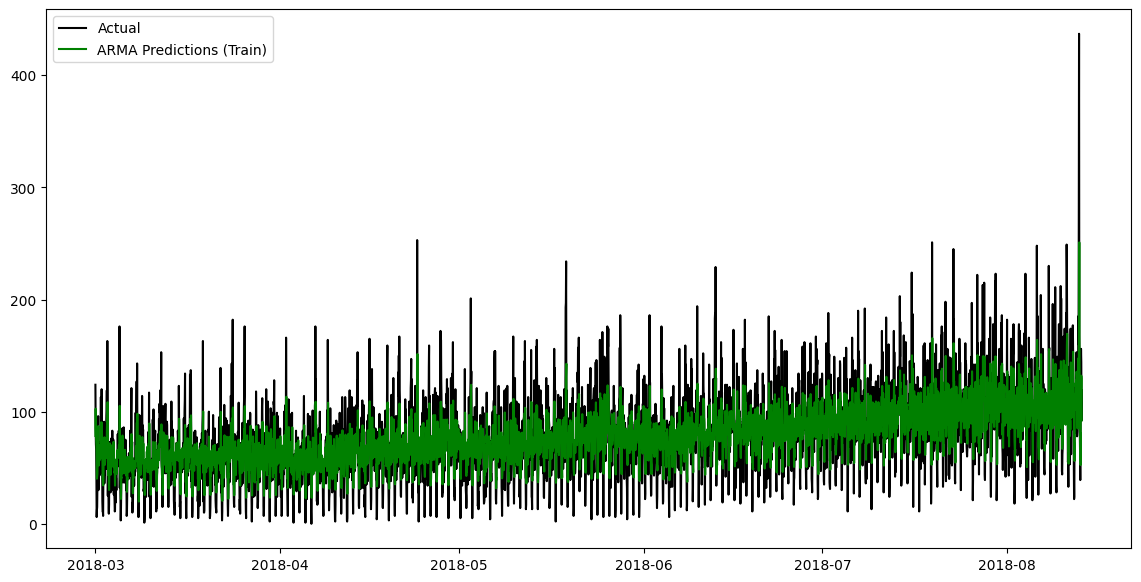

In [26]:
# refer to the image below

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['num_orders'], label='Actual', color='black')
plt.plot(arma_train_pred.index, arma_train_pred, label='ARMA Predictions (Train)', color='green')
plt.legend()
plt.show()

## SARIMAX model

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.68716D+00    |proj g|=  2.58424D-01

At iterate    5    f=  4.62736D+00    |proj g|=  2.98283D-01

At iterate   10    f=  4.62434D+00    |proj g|=  1.70752D-02

At iterate   15    f=  4.61083D+00    |proj g|=  2.49185D-01

At iterate   20    f=  4.60839D+00    |proj g|=  2.31501D-01

At iterate   25    f=  4.50488D+00    |proj g|=  9.78429D-01

At iterate   30    f=  4.47724D+00    |proj g|=  3.43767D-01

At iterate   35    f=  4.47621D+00    |proj g|=  2.98523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

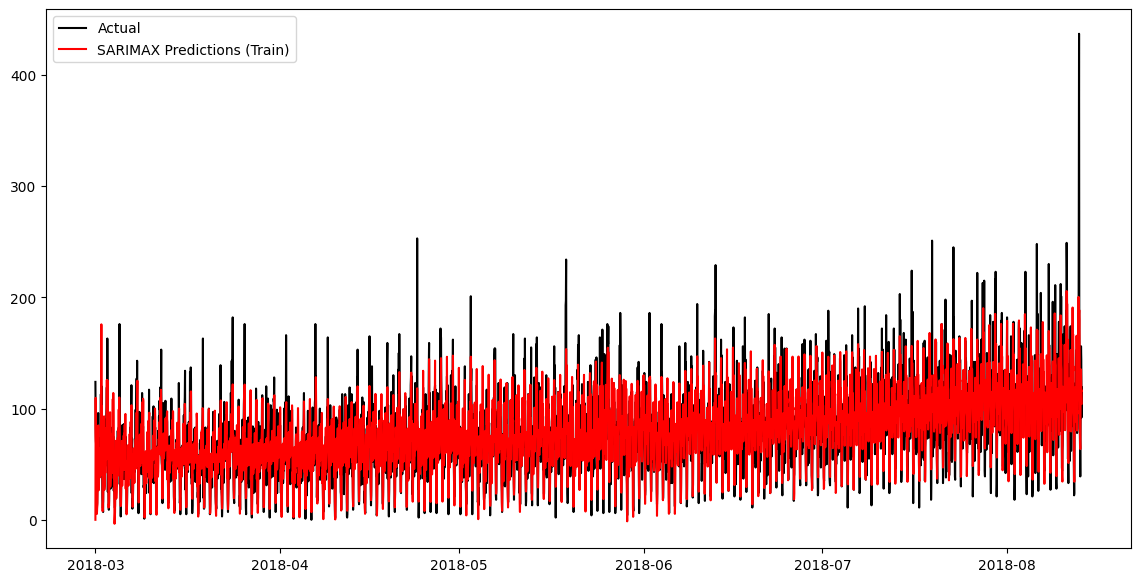

In [27]:
p = 1 # Training RMSE: 22.05
d = 0
q = 1
P = 1
D = 0
Q = 1
s = 24


sarimax_model = SARIMAX(train['num_orders'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = sarimax_model.fit()
print(results.summary())


# Predict on the training data
sarima_train_pred = results.predict(start=train.index[0], end=train.index[-1])

# Calculate RMSE
train_rmse = sqrt(mean_squared_error(train['num_orders'], sarima_train_pred))
print(f'Training RMSE: {train_rmse}')


# refer to the image below

#model results plotted
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['num_orders'], label='Actual', color='black')
plt.plot(sarima_train_pred.index, sarima_train_pred, label='SARIMAX Predictions (Train)', color='red')
plt.legend()
plt.show()

SARIMAX Model: SARIMAX(1, 0, 1)x(1, 0, 1, 24) | 
Training RMSE: 22.05934984623976
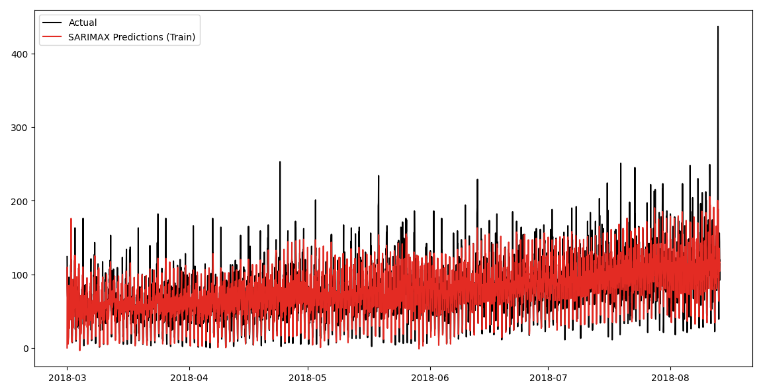

In order of model performance: SARIMAX did the best (with the lowest score - 22.05), AR was second-best (25.57 RMSE Score) and lastly ARMA with worse and highest RMSE score (of 30.13); this is clearly evident in how closely the models followed the trend closely as they can and why SARIMA did the best of all. But also since SARIMAX does take in account for seasonality (and clearly shown how relatively well it was at capturing it hence why,) that is another reasoning for why it did well with scoring. But I will say, all models could be struggling with volatility towards the end of the time series, as it seems like some of the spikes/peaks (whether high or low) aren't as well-captured.

## Testing

SARIMAX Model Test RMSE: 45.36298301071329


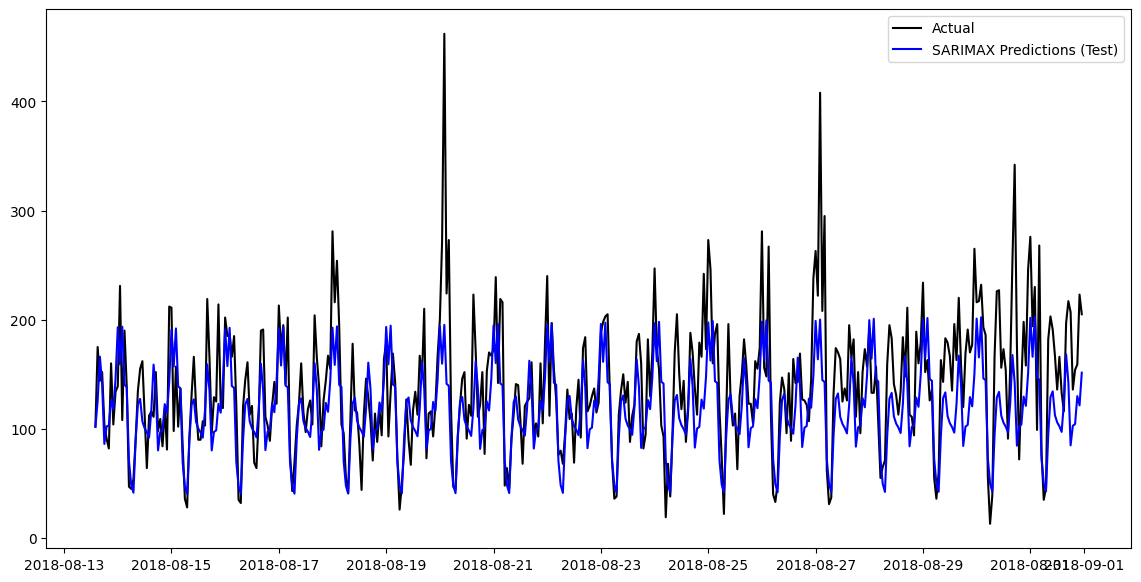

In [28]:
# Forecast on the test data
start_value = len(train)
end_value = len(train) + len(test) - 1
sarimax_test_pred = results.get_forecast(steps=len(test)).predicted_mean

# Calculate RMSE for test data
sarimax_test_rmse = sqrt(mean_squared_error(test['num_orders'], sarimax_test_pred))
print(f"SARIMAX Model Test RMSE: {sarimax_test_rmse}")

# refer to the image above

plt.figure(figsize=(14, 7))
plt.plot(test.index, test['num_orders'], label='Actual', color='black')
plt.plot(test.index, sarimax_test_pred, label='SARIMAX Predictions (Test)', color='blue')
plt.legend()
plt.show()

SARIMAX Model Test RMSE: 45.36298301071329
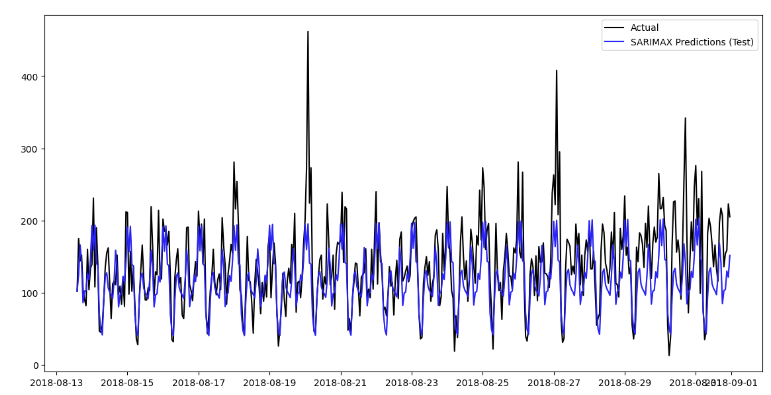

I can definitely see that the model captures the *general trend and like cyclical patterns* of the actual (daily/weekly) data but I also can definitely see how the model definitely didn't do well in catching some of the peak values. Also that comparitively to its training score (of 22.05) it grew twice as big in some degree to due maybe overfitting/missing outliers? Or maybe it wasn't going to innately do as well as I thought it would on unseen data although I do understand overfitting is quite common. So I think this would be okay to use on like a general forecasting understand of the data (on a daily or weekly basis) to see a general trend but maybe not so much on long-term, monthly predicitions until the model's volatility is addressed (and for the other models as well). 

As an overall conclusion, I definitely can see myself focusing heavily more in-depth on Time Series by learning more about the nitty, gritty details about how to fine-tune an optimal model for forecasting data and or using ML models in tandem or replacement of when dealing with data with a lot of outliers or volatility. Because I think the volatility in the models is what stuck with me, when compared with the actual data (i.e. the black series) as it shows maybe all models had no struggle to catch the patterns/trends/seasonalities relatively but definitely in the later months or even overall in certain area they definitely struggled, which would maybe imply dealing with outliers and over/underfitting a bit more of a challenge when dealing with Time Series data.